In [42]:
import os
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

CWD = os.getcwd()

# If necessary, change these paths to your hardcoded paths.
CSET_DATA_HOME_PATH = os.path.join(CWD, os.pardir)
DATA_DIRECTORY_PATH = os.path.join(CSET_DATA_HOME_PATH, "data")

# These paths depend on the correctness of the above base paths.
CONFIGURATIONS_PARQUET_PATH            = os.path.join(DATA_DIRECTORY_PATH, "configurations.parquet")
ZIPPED_PACKET_CAPTURE_SIZES_CSV_PATH   = os.path.join(DATA_DIRECTORY_PATH, "zipped_packet_captures.csv")
GIGABIT_ATTACK_DECODE_TIMES_TEXT_PATH  = os.path.join(DATA_DIRECTORY_PATH, "gigabit_attack_decode_times.txt")
CLOUD_DECODE_TIMES_TEXT_PATH           = os.path.join(DATA_DIRECTORY_PATH, "cloud_decode_times.txt")
UNZIPPED_PACKET_CAPTURE_SIZES_CSV_PATH = os.path.join(DATA_DIRECTORY_PATH, "unzipped_packet_captures.csv")

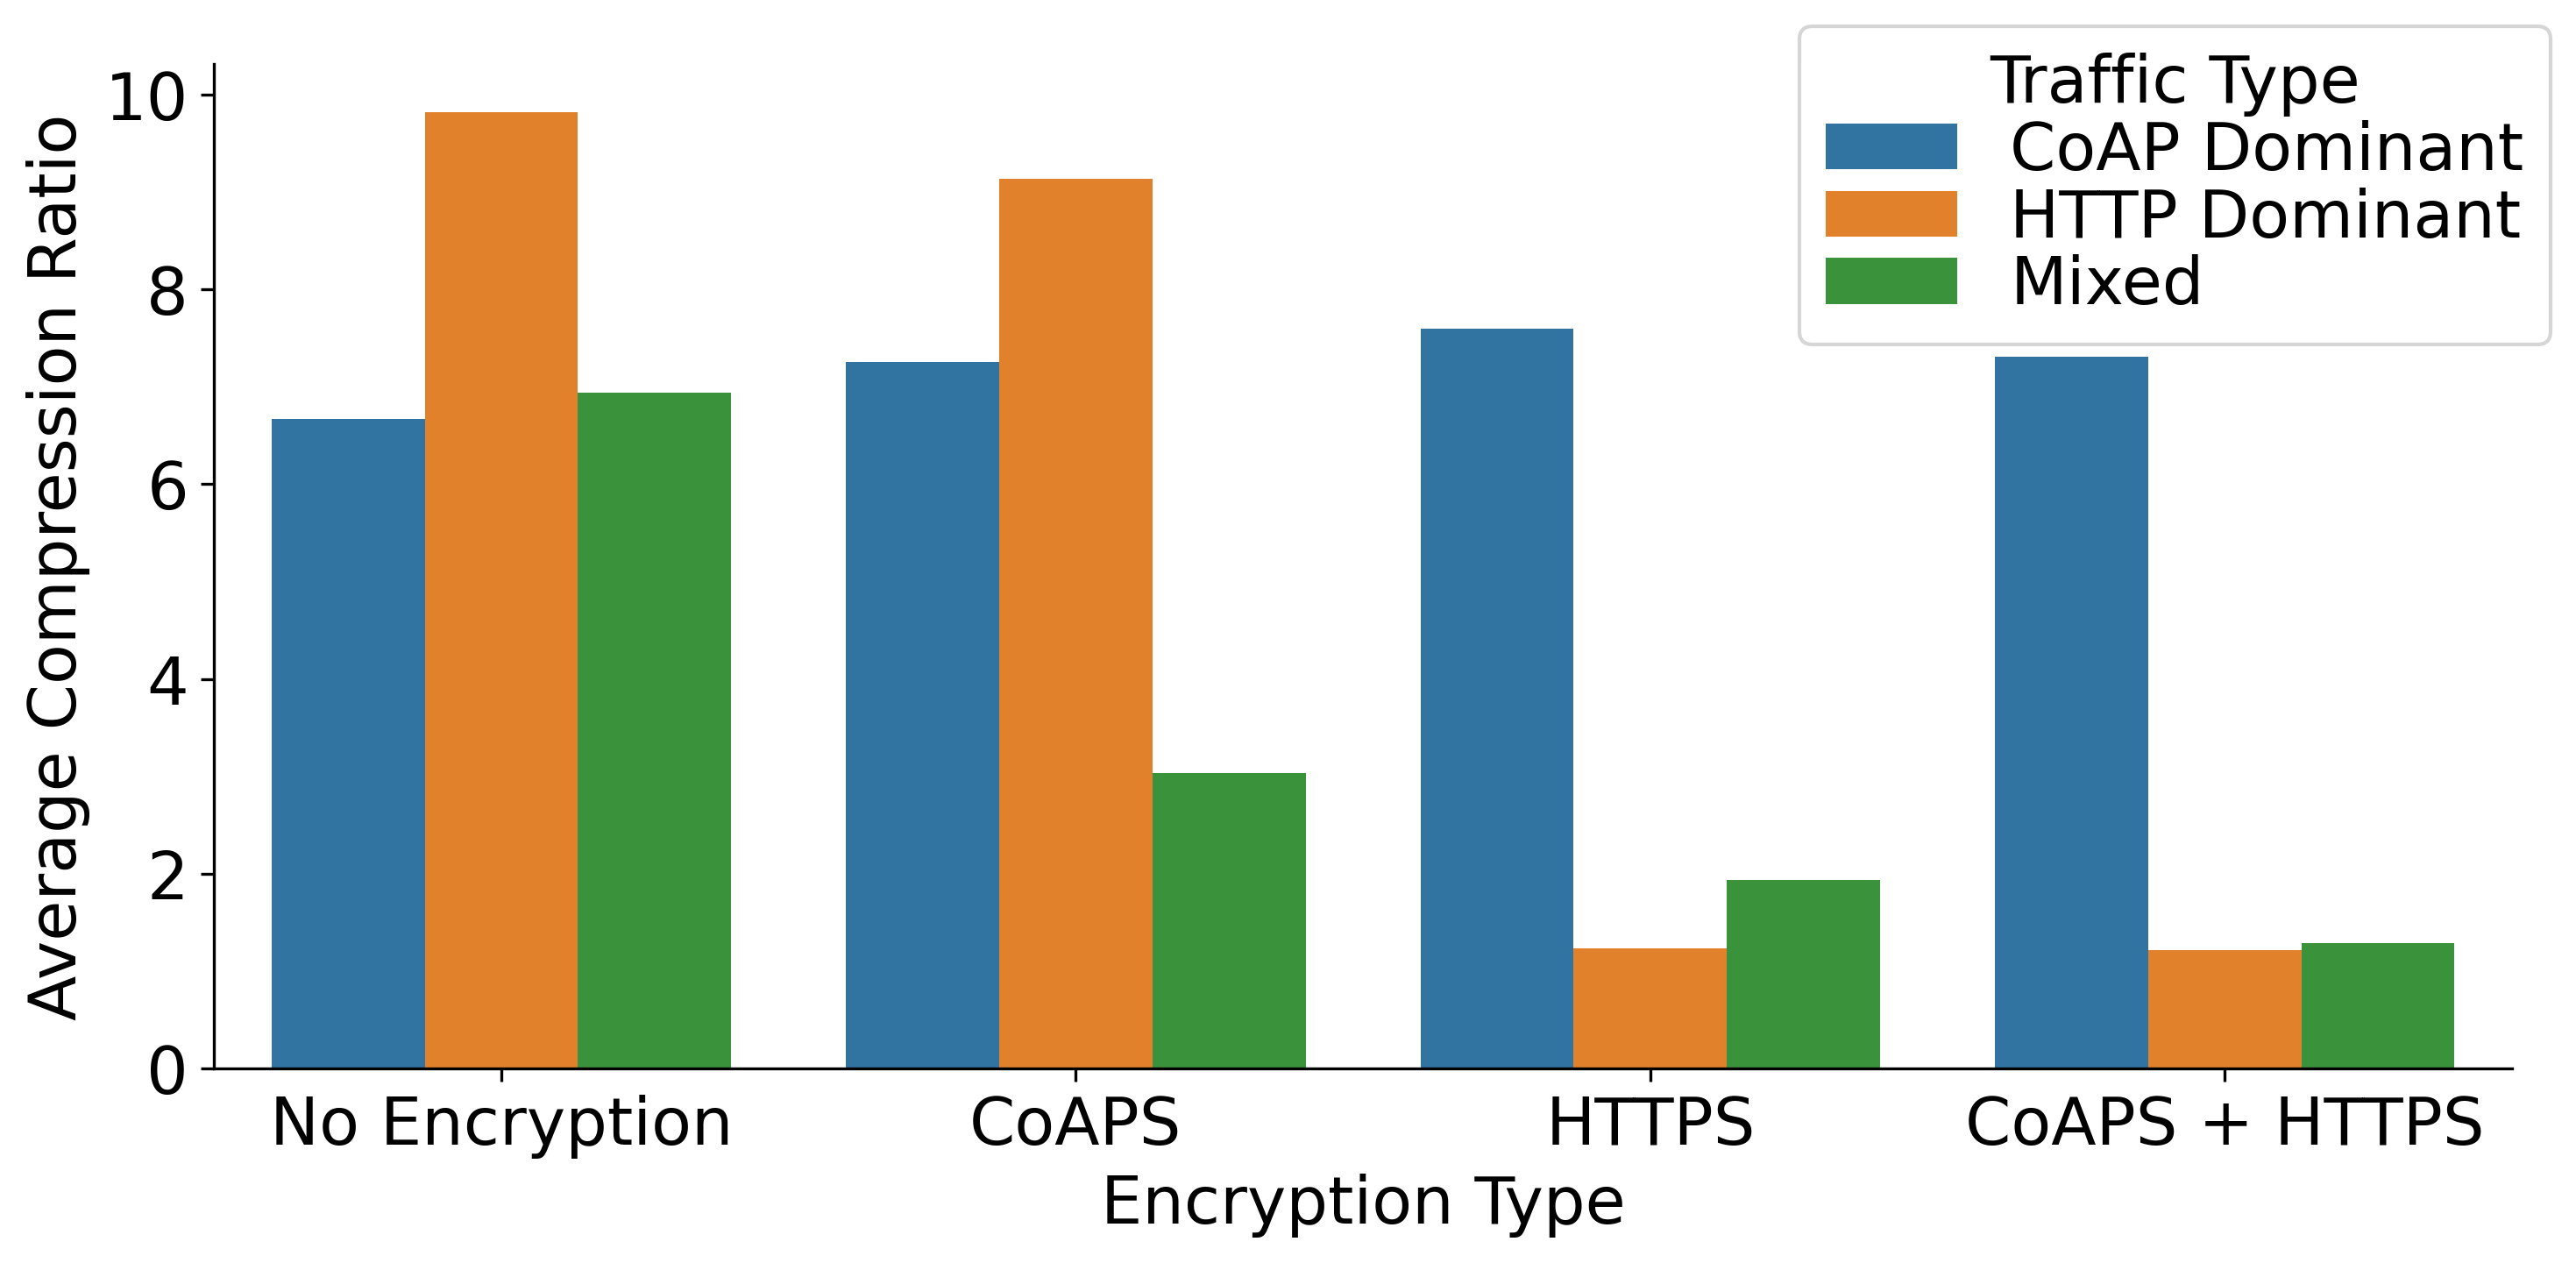

CPU times: user 1.11 s, sys: 193 ms, total: 1.3 s
Wall time: 819 ms


,exp_id,trial,capture,unzipped_size,zipped_size,compression_ratio,attacker_rate,dtls,https,run_attacker,capture_distribution,encryption
0,cloud_proxy_and_500mbpsattacker_withattacker,1,attacker_dump,61737825,9987428,6.181554,500mbps,False,False,True,CoAP Dominant,No Encryption
1,cloud_proxy_and_500mbpsattacker_withattacker,1,client_dump,399317,79561,5.019004,500mbps,False,False,True,CoAP Dominant,No Encryption
2,cloud_proxy_and_500mbpsattacker_withattacker,1,proxy_dump,156279922,23349749,6.693002,500mbps,False,False,True,Mixed,No Encryption
3,cloud_proxy_and_500mbpsattacker_withattacker,1,receiver_dump,37880006,7604858,4.981027,500mbps,False,False,True,CoAP Dominant,No Encryption
4,cloud_proxy_and_500mbpsattacker_withattacker,1,server_dump,59321304,5536648,10.714299,500mbps,False,False,True,HTTP Dominant,No Encryption
...,...,...,...,...,...,...,...,...,...,...,...,...
163,cloud_proxy_and_attacker_withattacker_httpson,3,attacker_dump,64031575,10189835,6.283868,100mbps,False,True,True,CoAP Dominant,HTTPS
164,cloud_proxy_and_attacker_withattacker_httpson,3,client_dump,407977,80762,5.051596,100mbps,False,True,True,CoAP Dominant,HTTPS
165,cloud_proxy_and_attacker_withattacker_httpson,3,proxy_dump,157809292,68367983,2.308234,100mbps,False,True,True,Mixed,HTTPS
166,cloud_proxy_and_attacker_withattacker_httpson,3,receiver_dump,37315014,7615720,4.899736,100mbps,False,True,True,CoAP Dominant,HTTPS


In [39]:
%%time

###
### Generate Figure 3 in the paper.
###

# Read unzipped capture sizes.
unzipped_capture_sizes_df = pd.read_csv(UNZIPPED_PACKET_CAPTURE_SIZES_CSV_PATH)
unzipped_capture_sizes_df["zipped"] = False

# Read zipped capture sizes.
zipped_capture_sizes_df = pd.read_csv(ZIPPED_PACKET_CAPTURE_SIZES_CSV_PATH)
zipped_capture_sizes_df["zipped"] = True

# Exract experiment ID, trial number, and capture name
# from the recorded capture directories.
detailed_records = list()
for r in pd.concat([unzipped_capture_sizes_df, zipped_capture_sizes_df]).to_dict(orient="records"):
  dr = {**r}
  parts = r["exp_id"].split("/")
  dr["exp_id"] = parts[0]
  dr["trial"] = parts[1]
  dr["capture"] = parts[2].replace("client1", "client").replace(".zip", "").replace(".pcap", "")
  detailed_records.append(dr)
capture_sizes_df = pd.DataFrame.from_records(detailed_records)

grouped_capture_sizes_df = (
  capture_sizes_df
  .groupby(by=["exp_id", "trial", "capture"])
  .agg(
    unzipped_size=("size", "max"),
    zipped_size=("size", "min"),
  )
  .reset_index()
)
grouped_capture_sizes_df["compression_ratio"] = grouped_capture_sizes_df["unzipped_size"] / grouped_capture_sizes_df["zipped_size"]

# Read experiment configurations and combine with
# capture size data.
configurations_df = pl.read_parquet(CONFIGURATIONS_PARQUET_PATH).to_pandas()
configurations_df = configurations_df[["exp_id", "attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https", "run_attacker"]]
merged_df = grouped_capture_sizes_df.merge(configurations_df, on="exp_id")

# Massage capture values for grouping and plotting.
merged_df["capture_distribution"] = merged_df["capture"]
merged_df.capture_distribution.replace({
  "attacker_dump": "CoAP Dominant",
  "client_dump": "CoAP Dominant",
  "proxy_dump": "Mixed",
  "receiver_dump": "CoAP Dominant",
  "server_dump": "HTTP Dominant",
}, inplace=True)
merged_df.rename(columns={
  "run_proxy_with_dtls": "dtls",
  "run_proxy_with_https": "https",
  "capture_distribution": "capture_distribution",
}, inplace=True)
merged_df

# Classify encryption schemes.
merged_df["encryption"] = ""
merged_df.loc[(merged_df["dtls"] == False) & (merged_df["https"] == False), "encryption"] = "No Encryption"
merged_df.loc[(merged_df["dtls"] == False) & (merged_df["https"] == True), "encryption"] = "HTTPS"
merged_df.loc[(merged_df["dtls"] == True) & (merged_df["https"] == False), "encryption"] = "CoAPS"
merged_df.loc[(merged_df["dtls"] == True) & (merged_df["https"] == True), "encryption"] = "CoAPS + HTTPS"

g = sns.catplot(
  data=merged_df,
  kind="bar",
  ci=None,
  x="encryption",
  y="compression_ratio",
  order=["No Encryption", "CoAPS", "HTTPS", "CoAPS + HTTPS"],
  hue="capture_distribution",
  hue_order=["CoAP Dominant", "HTTP Dominant", "Mixed"],
  legend_out=False,
  height=5,
  aspect=2,
)

g.set(xlabel="Encryption Type", ylabel="Average Compression Ratio")
sns.move_legend(
  g, 
  "upper right", 
  title="Traffic Type", 
  frameon=True, 
  labelspacing=0.05,
  bbox_to_anchor=((1, 1)),
  markerfirst=True,
)

plt.show()

merged_df

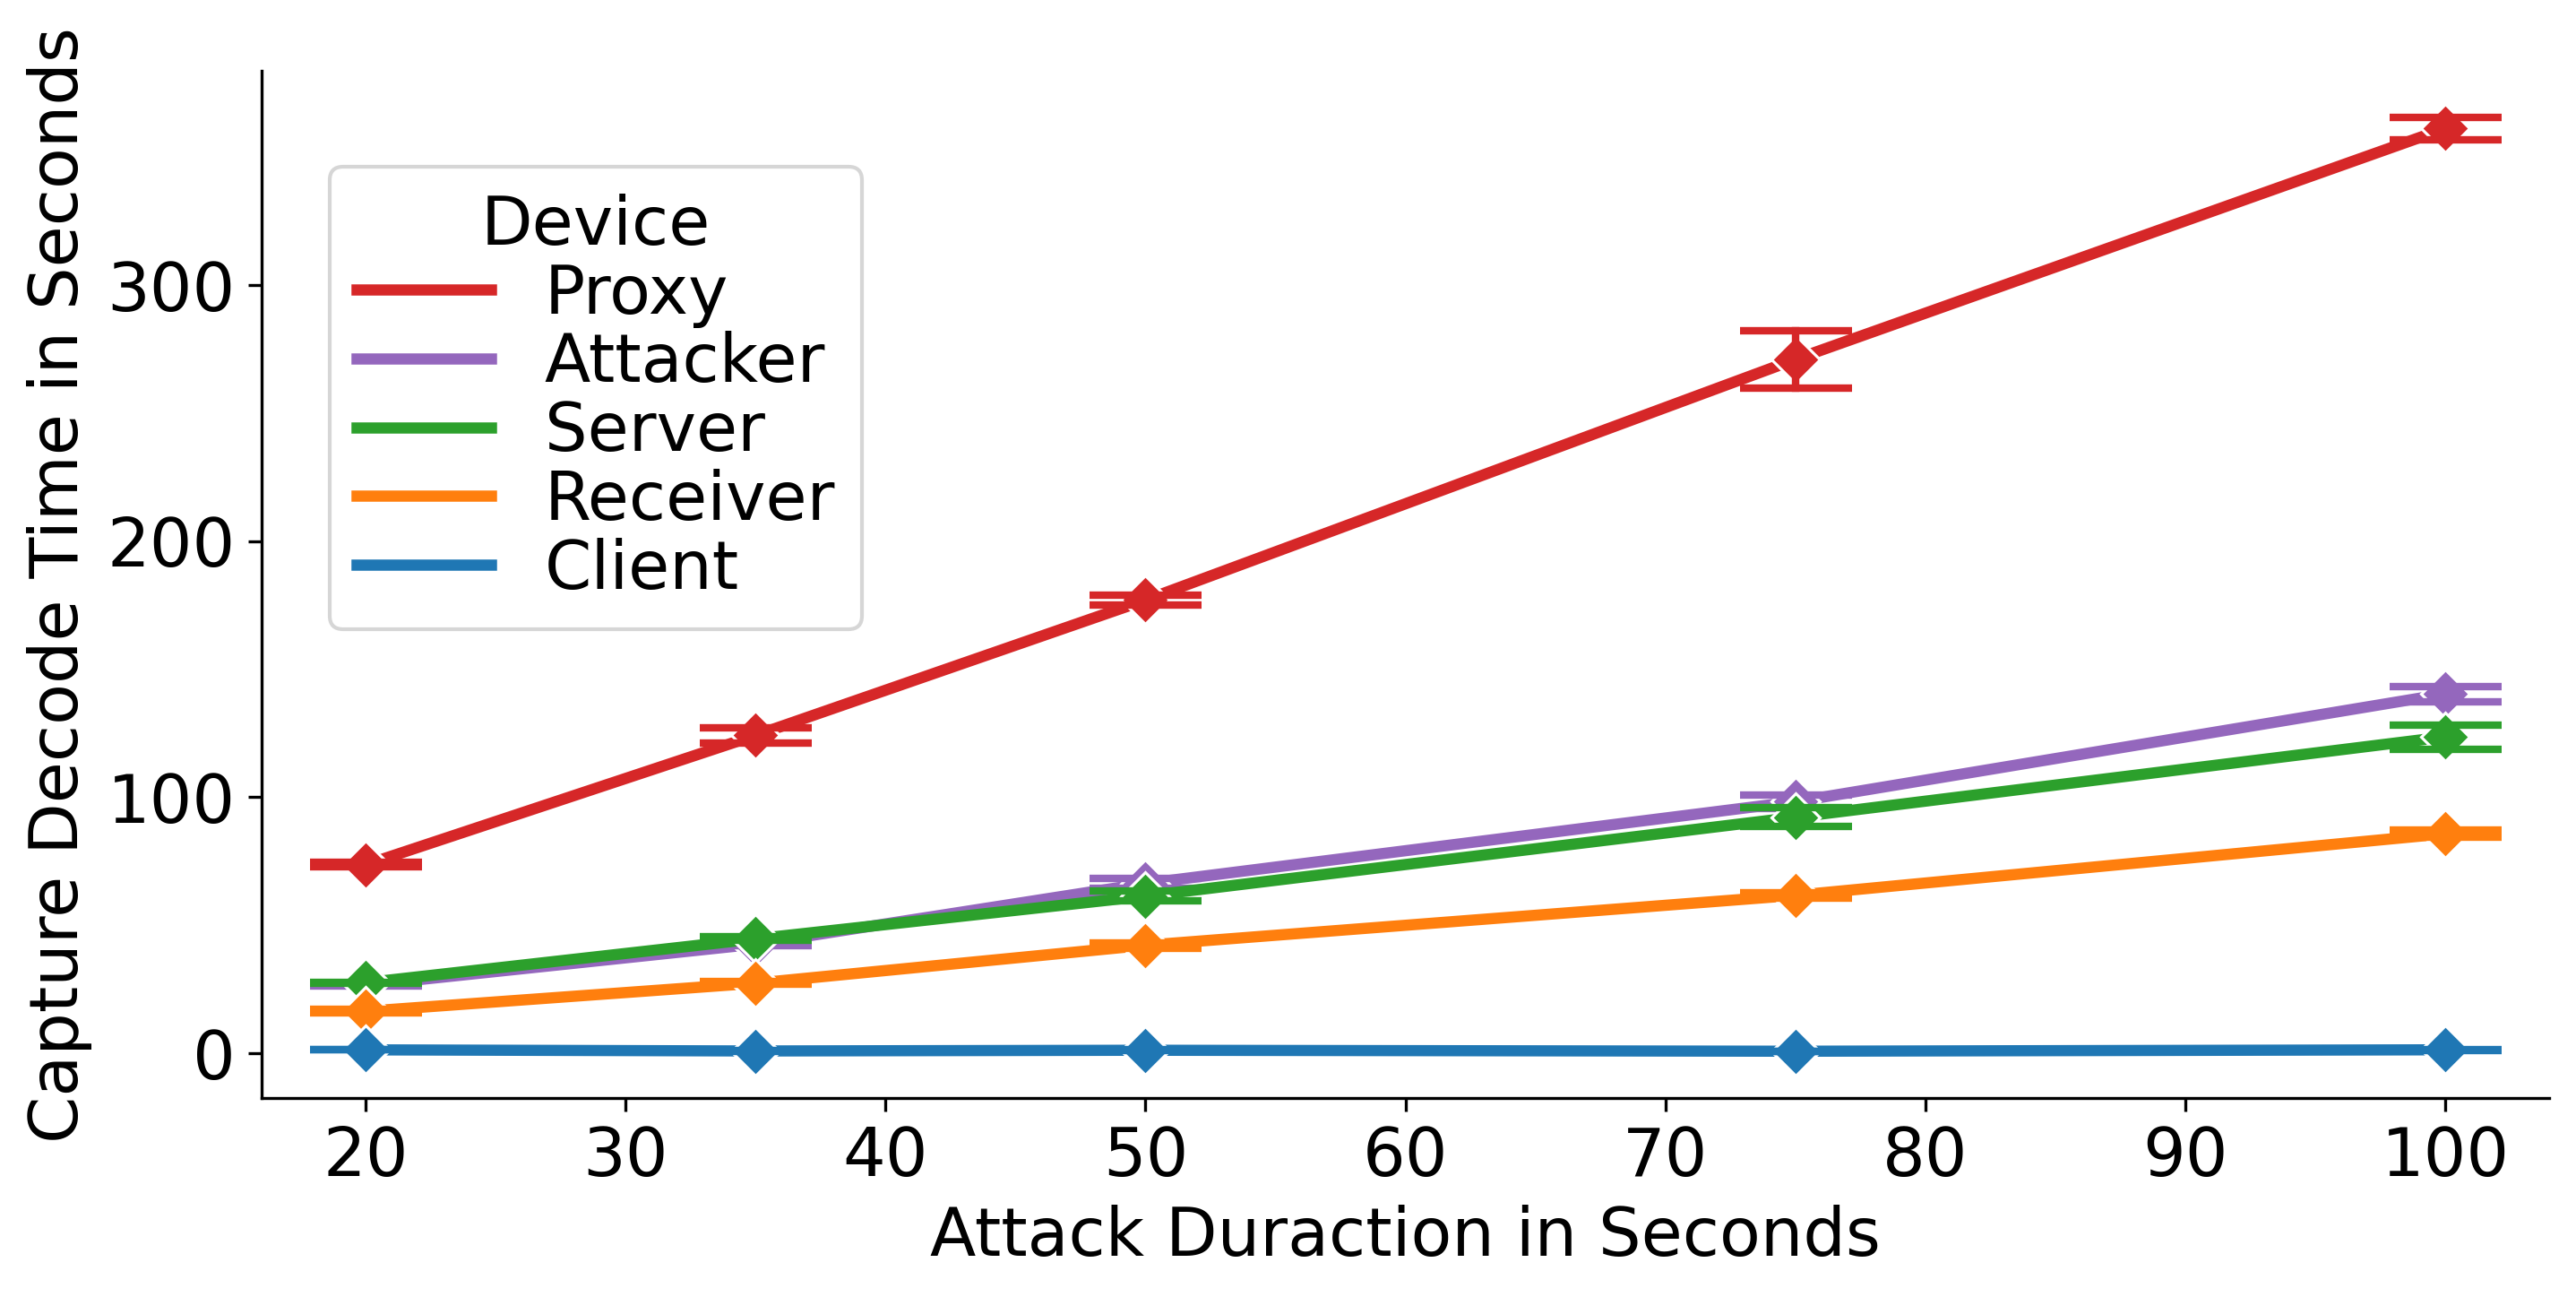

CPU times: user 1.16 s, sys: 167 ms, total: 1.33 s
Wall time: 1.01 s


,exp_id,attack_volume,capture,avg_decode_time,attack_duration_sec
0,gigabit_attack_20sec_with_tcpdump,2500,Receiver,16.275000,20
1,gigabit_attack_20sec_with_tcpdump,2500,Attacker,26.442000,20
2,gigabit_attack_20sec_with_tcpdump,2500,Client,1.198333,20
3,gigabit_attack_20sec_with_tcpdump,2500,Proxy,73.531000,20
4,gigabit_attack_20sec_with_tcpdump,2500,Server,27.432667,20
5,gigabit_attack_35sec_with_tcpdump,4375,Server,44.577000,35
6,gigabit_attack_35sec_with_tcpdump,4375,Receiver,27.249000,35
7,gigabit_attack_35sec_with_tcpdump,4375,Client,0.759000,35
8,gigabit_attack_35sec_with_tcpdump,4375,Attacker,42.503333,35
9,gigabit_attack_35sec_with_tcpdump,4375,Proxy,124.093000,35


In [46]:
%%time

###
### Generate Figure 4 in the paper.
###

line_replacements = [
  ("\t", " "),
  ("-real ", "/real/"),
  (":real ", "/real/"),
  (":", "/"),
  ("-", "/"),
]

def parse_decode_time_to_dict(decode_text_path):
  """
  Parse decode times into group, experiment, capture, and decode time.
  Decode time lines to come in pairs. The lines and their parsing results
  are expected as below:
  
  [Lines]
  "file_no2_gigabit_attack_100sec_with_tcpdump/process_gigabit_attack_100sec_with_tcpdump.log/attacker_dump.pcap"
  "file_no2_gigabit_attack_100sec_with_tcpdump/process_gigabit_attack_100sec_with_tcpdump.log/real/2m23.372s"
  
  [Results]
  Group ID         : "no2_gigabit_attack_100sec_with_tcpdump"
  Experiment ID    : "gigabit_attack_100sec_with_tcpdump"
  Device Capture   : "Attacker"
  Decode Time [Sec]: "143.372"
  """
  d = list()
  with open(decode_text_path, "r") as f:
    for i, L in enumerate(f):
      # Split each line by path delimiter "/".
      L = L.rstrip()
      for old, new in line_replacements:
        L = L.replace(old, new)
      parts = L.split("/")

      # Extract group and experiment IDs.
      group_id = parts[0].replace("file_", "")
      exp_id = parts[1].replace("process_", "").replace(".log", "")

      # Extract the device capture name or decode time
      # depending on the parity of the line.
      if i % 2 == 0:
        dump = (
          parts[-1]
          .replace("client1", "client")
          .replace("_dump.pcap", "")
          .title()
        )
        d.append({
          "group_id": group_id,
          "exp_id": exp_id,
          "capture": dump,
          "decode_time_sec": None
        })
      else:
        s = parts[-1]
        mins = int(s[:s.index("m")])
        secs = float(s[s.index("m")+1:-1])
        d[-1]["decode_time_sec"] = mins*60 + secs
  return d
  
decode_records = parse_decode_time_to_dict(GIGABIT_ATTACK_DECODE_TIMES_TEXT_PATH)
decode_times_df = pd.DataFrame.from_dict(decode_records)

# Note attack volume and duration for each experiment.
experiment_volume_df = pd.DataFrame.from_records([
  {"exp_id": "cloud_proxy_and_attacker_withattacker", "attack_volume": 250, "duration_sec": 20,},
  {"exp_id": "megabit300_attack_20sec_with_tcpdump", "attack_volume": 750, "duration_sec": 20,},
  {"exp_id": "megabit750_attack_20sec_with_tcpdump", "attack_volume": 1875, "duration_sec": 20,},
  {"exp_id": "gigabit_attack_20sec_with_tcpdump", "attack_volume": 2500, "duration_sec": 20,},
  {"exp_id": "gigabit_attack_35sec_with_tcpdump", "attack_volume": 4375, "duration_sec": 35,},
  {"exp_id": "gigabit_attack_50sec_with_tcpdump", "attack_volume": 6250, "duration_sec": 50,},
  {"exp_id": "gigabit_attack_75sec_with_tcpdump", "attack_volume": 9375, "duration_sec": 75,},
  {"exp_id": "gigabit_attack_100sec_with_tcpdump", "attack_volume": 12500, "duration_sec": 100,},
])
decode_times_df = decode_times_df.merge(experiment_volume_df, on="exp_id")

# Keep only experiments with a gigabit attack rate, for a fair comparison.
decode_times_df = decode_times_df[decode_times_df["exp_id"].str.startswith("gigabit_attack")]

# Compute average decode times across experiments, volumes, and captures.
grouped_decode_times_df = (
  decode_times_df
  .groupby(by=["exp_id", "attack_volume", "capture"])
  .agg(
    avg_decode_time=("decode_time_sec", "mean"),
    attack_duration_sec=("duration_sec", "max")
  )
  .sort_values(by="attack_volume")
  .reset_index()
)

g = sns.relplot(
  data=decode_times_df,
  kind="line",
  ci="sd",
  err_style="bars",
  x="duration_sec",
  y="decode_time_sec",
  hue="capture",
  hue_order=[
    'Proxy',
    'Attacker',
    'Server',
    'Receiver',
    'Client',
  ],
  palette={
    'Proxy': "tab:red",
    'Attacker': "tab:purple",
    'Server': "tab:green",
    'Receiver': "tab:orange",
    'Client': "tab:blue",
  },
  marker='D',
  height=5,
  aspect=2,
  err_kws={
    "elinewidth": 2,
    "capthick": 2,
    "capsize": 15,
  }
)

g.set(xlabel="Attack Duraction in Seconds", ylabel="Capture Decode Time in Seconds")
sns.move_legend(
  g, 
  "upper left", 
  title="Device", 
  frameon=True, 
  labelspacing=0.05,
  bbox_to_anchor=(.125, .9),
  markerfirst=True,
)
plt.show()

grouped_decode_times_df

In [52]:
%%time

###
### Generate Table 3 in the paper.
###

# Parse decode times for the cloud experiments.
cloud_decode_records = parse_decode_time_to_dict(CLOUD_DECODE_TIMES_TEXT_PATH)
cloud_decode_times_df = pd.DataFrame.from_dict(cloud_decode_records)

# Merge cloud decode times with experiment configurations.
cloud_decode_times_df = cloud_decode_times_df.merge(configurations_df, on="exp_id")

# Merge cloud decode times with experiment attack volumes.
volume_df = pd.DataFrame.from_dict({
  'cloud_proxy_and_attacker_withattacker_httpson' : "High",
  'cloud_proxy_and_500mbpsattacker_withattacker' : "High",
  'cloud_proxy_and_attacker_withattacker' : "High",
  'cloud_proxy_and_attacker_withattacker_dtlson_httpson' : "Medium",
  'cloud_proxy_and_500mbpsattacker_withattacker_httpson' : "Medium",
  'cloud_proxy_and_500mbpsattacker_withattacker_dtlson' : "Medium",
  'cloud_proxy_and_500mbpsattacker_withattacker_dtlson_httpson' : "Medium",
  'cloud_proxy_and_attacker_withattacker_dtlson' : "Medium",
  'cloud_proxy_and_attacker_noattacker_dtlson' : "Low",
  'cloud_proxy_and_attacker_noattacker_dtlson_httpson' : "Low",
  'cloud_proxy_and_attacker_noattacker' : "Low",
  'cloud_proxy_and_attacker_noattacker_httpson' : "Low",
}, orient="index", columns=["volume"]).reset_index().rename(columns={"index": "exp_id"})
cloud_decode_times_df = cloud_decode_times_df.merge(volume_df, on="exp_id")

cloud_decode_times_df

# Get each capture's mean decode time (and more stats), grouped by attack volume.
(
  cloud_decode_times_df
  .groupby(by=["volume", "capture"])
  .agg(
    mean_decode_time_sec=("decode_time_sec", "mean"),
    median_decode_time_sec=("decode_time_sec", "median"),
    max_decode_time_sec=("decode_time_sec", "max"),
    p99_decode_time_sec=("decode_time_sec", lambda x: x.quantile(0.95)),
  )
)

CPU times: user 63.5 ms, sys: 5.68 ms, total: 69.2 ms
Wall time: 65.4 ms


mean_decode_time_sec  median_decode_time_sec  \
volume capture                                                  
High   Attacker            128.921500                128.7325   
       Client               11.315204                 10.6090   
       Proxy               166.509537                164.5940   
       Receiver            101.224426                100.2185   
       Server              100.197315                 99.4660   
Low    Client               11.682806                 10.6780   
       Proxy                15.646903                 14.6050   
       Receiver             10.170514                  9.0475   
       Server               13.772597                 12.4625   
Medium Attacker             76.167056                 75.8925   
       Client               11.860889                 10.6085   
       Proxy               117.323478                116.0345   
       Receiver              9.868544                  8.9875   
       Server               87.267356                 87.0400   

                 max_decode_time_sec  p99_decode_time_sec  
volume capture                                             
High   Attacker              139.354            137.71230  
       Client                 16.672             15.81950  
       Proxy                 177.807            175.55675  
       Receiver              109.965            109.21540  
       Server                114.073            107.69600  
Low    Client                 17.163             16.68925  
       Proxy                  21.444             20.71345  
       Receiver               15.386             14.78540  
       Server                 18.996             18.50175  
Medium Attacker               89.542             83.22140  
       Client                 17.688             17.15650  
       Proxy                 135.134            125.31620  
       Receiver               15.387             14.92770  
       Server                101.392             98.08810